<a href="https://colab.research.google.com/github/khalidpark/project-LogSecurity/blob/main/project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기 및 간단 EDA

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
train=pd.read_csv('/content/train.csv', error_bad_lines=False, engine="python")

In [ ]:
print(train.shape)

(472972, 3)


In [ ]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [ ]:
print(train['full_log'][0])

Sep 24 10:02:22 localhost kibana: {"type":"error","@timestamp":"2020-09-24T01:02:22Z","tags":["warning","stats-collection"],"pid":6458,"level":"error","error":{"message":"No Living connections","name":"Error","stack":"Error: No Living connections\n    at sendReqWithConnection (/usr/share/kibana/node_modules/elasticsearch/src/lib/transport.js:226:15)\n    at next (/usr/share/kibana/node_modules/elasticsearch/src/lib/connection_pool.js:214:7)\n    at process._tickCallback (internal/process/next_tick.js:61:11)"},"message":"No Living connections"}


In [ ]:
print(train['full_log'][1])

Feb  8 16:21:00 localhost logstash: [2021-02-08T16:21:00,548][INFO ][logstash.outputs.elasticsearch] retrying failed action with response code: 503 ({"type"=>"unavailable_shards_exception", "reason"=>"[wazuh-alerts-audit-3.x-2021.16.08][3] primary shard is not active Timeout: [1m], request: [BulkShardRequest [[wazuh-alerts-audit-3.x-2021.16.08][3]] containing [25] requests]"})


### full_log 분석

full log는 딕셔너리 형식

데이터의 형식이고정되어있지 않아, 위험 키워드를 특정하거나 수치만을 활용하는 방법이 필요하다 판단됨.


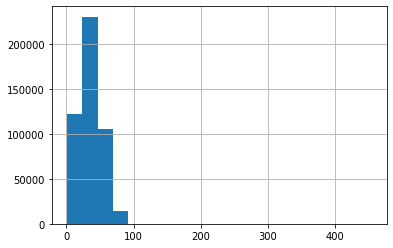

In [ ]:
#train full_log의 길이 확인
train['full_log'].str.split(' ').str.len().hist(bins=20)

In [ ]:
#train level별 값 확인
train['level'].value_counts()

0    334065
1    132517
3      4141
5      2219
2        12
4        10
6         8
Name: level, dtype: int64

### 분포분석

보안위험이 0 인 분포의 비율이 70%이므로 분포의 가중치를 유의하여 모델에 적용해야함



---



# 데이터전처리 및 모델링

## 머신러닝

### 방법1) 숫자를 마스킹 처리한 뒤, CountVectorizer 처리 후 randomforest

In [ ]:
train_1 = train

In [ ]:
#full_log에서 숫자는 마스킹 처리
train_1['full_log']=train_1['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
#train['full_log'] => train_text로 list
#train['level']=> train_level로 array
train_text_1=list(train_1['full_log'])
train_level_1=np.array(train_1['level'])

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features_1=vectorizer.fit_transform(train_text_1)

In [ ]:
train_features_1

<472972x13214 sparse matrix of type '<class 'numpy.int64'>'
	with 16455803 stored elements in Compressed Sparse Row format>

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_1,x_val_1, y_train_1, y_val_1=train_test_split(train_features_1, train_level_1, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [ ]:
#랜덤포레스트로 모델링
from sklearn.ensemble import RandomForestClassifier

model_1=RandomForestClassifier(n_estimators=100)

model_1.fit(x_train_1, y_train_1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#모델 검증
model_1.score(x_val_1, y_val_1)

0.9979280088799619

In [ ]:
#crosstab으로 확인
pred_1=model_1.predict(x_val_1)
crosstab_1 = pd.crosstab(y_val_1, pred_1, rownames=['real'], colnames=['pred'])
crosstab_1

pred,0,1,2,3,4,5
real,,,,,,
0,66728,56,0,0,0,2
1,117,26429,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,12,3,0,0,0,438
6,1,0,0,2,0,0


In [ ]:
from sklearn import metrics
metrics.f1_score(y_val_1, pred_1, average='macro')

0.8532283553877571

### 방법2) 숫자를 마스킹 처리한 뒤, TfidfVectorizer 처리 후 randomforest

In [104]:
train_2 = train

In [105]:
train_2['full_log']=train_2['full_log'].str.replace(r'[0-9]', '<num>')

In [106]:
# Tfidf 기반 피쳐 벡터화 변환
tfidf_vec = TfidfVectorizer(min_df=0,ngram_range=(2,2),max_features=10000)
train_text_2 = tfidf_vec.fit_transform(train_2['full_log'])
train_level_2=np.array(train_2['level'])


In [107]:
TEST_SIZE=0.2
RANDOM_SEED=42

x_train_2,x_val_2, y_train_2, y_val_2=train_test_split(train_text_2, train_level_2, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [108]:
from sklearn.ensemble import RandomForestClassifier

model_2=RandomForestClassifier(n_estimators=100)

model_2.fit(x_train_2, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [109]:
#방법2의 vectorize 이 더 우수한걸로 파악됨

model_2.score(x_val_2, y_val_2)

0.9979491516464929

In [110]:
#crosstab으로 확인
pred_2=model_2.predict(x_val_2)
crosstab_2 = pd.crosstab(y_val_2, pred_2, rownames=['real'], colnames=['pred'])
crosstab_2

pred,0,1,2,3,4,5
real,,,,,,
0,66737,48,0,0,0,1
1,123,26423,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,14,2,0,0,0,437
6,1,0,0,2,0,0




---



### 방법3) 숫자를 마스킹 처리한 뒤, TfidfVectorizer 처리 후 XGBClassifier

In [ ]:
train_3 = train

In [ ]:
train_3['full_log']=train_3['full_log'].str.replace(r'[0-9]', '<num>')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier

In [ ]:
# Tfidf 기반 피쳐 벡터화 변환
tfidf_vec = TfidfVectorizer(min_df=0,ngram_range=(2,2),max_features=10000)
train_text_3 = tfidf_vec.fit_transform(train_3['full_log'])

In [ ]:
train_level_3=np.array(train_3['level'])
x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(train_text_3, train_level_3, test_size=0.2, stratify=train_level_3, random_state = 42)

In [ ]:
# XGBClassifier

model_3 = XGBClassifier(booster='gbtree', 
                    colsample_bylevel=0.8, 
                    colsample_bytree=0.7, 
                    gamma=0, 
                    max_depth=5, learning_rate=0.15,
                    n_estimators=100, 
                    nthread=4,
                    objective = 'multi:softmax',
                    silent= False,
                    random_state = 42)

model_3.fit(x_train_3, y_train_3, eval_set=[(x_val_3, y_val_3)],
             early_stopping_rounds=10)
model_3.score(x_val_3, y_val_3)


[0]	validation_0-merror:0.002833
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.002336
[2]	validation_0-merror:0.002326
[3]	validation_0-merror:0.002315
[4]	validation_0-merror:0.002231
[5]	validation_0-merror:0.002241
[6]	validation_0-merror:0.00222
[7]	validation_0-merror:0.00222
[8]	validation_0-merror:0.00222
[9]	validation_0-merror:0.002199
[10]	validation_0-merror:0.002178
[11]	validation_0-merror:0.002178
[12]	validation_0-merror:0.002188
[13]	validation_0-merror:0.002188
[14]	validation_0-merror:0.002178
[15]	validation_0-merror:0.002167
[16]	validation_0-merror:0.002167
[17]	validation_0-merror:0.002167
[18]	validation_0-merror:0.002167
[19]	validation_0-merror:0.002093
[20]	validation_0-merror:0.002157
[21]	validation_0-merror:0.002093
[22]	validation_0-merror:0.002093
[23]	validation_0-merror:0.002083
[24]	validation_0-merror:0.00204
[25]	validation_0-merror:0.001998
[26]	validation_0-merror:0.001956
[27]	validation_0-merror:0.00

0.9980442940958825

In [ ]:
#모델 검증
model_3.score(x_val_3, y_val_3)

0.9980442940958825

In [ ]:
#crosstab으로 확인
pred_3 = model_3.predict(x_val_3)
crosstab_3 = pd.crosstab(y_val_3, pred_3, rownames=['real'], colnames=['pred'])
crosstab_3

pred,0,1,2,3,4,5,6
real,,,,,,,
0,66813,0,0,0,0,0,0
1,156,26348,0,0,0,0,0
2,0,0,2,0,0,0,0
3,7,0,0,821,0,0,0
4,0,0,0,0,2,0,0
5,21,0,0,0,0,423,0
6,1,0,0,0,0,0,1


In [ ]:
from sklearn import metrics
metrics.f1_score(y_val_3, pred_3, average='macro')

0.947695147264075

### 방법4) 숫자를 마스킹 처리한 뒤, TfidfVectorizer 처리 후 LGBMClassifier


In [95]:
train_4 = train

In [ ]:
train_4['full_log']=train_4['full_log'].str.replace(r'[0-9]', '<num>')

In [96]:
!pip install lightgbm

In [97]:
from lightgbm import LGBMClassifier

In [98]:
# Tfidf 기반 피쳐 벡터화 변환
tfidf_vec = TfidfVectorizer(min_df=0,ngram_range=(2,2),max_features=10000)
train_text_4 = tfidf_vec.fit_transform(train_4['full_log'])

In [100]:
train_level_4=np.array(train_4['level'])
x_train_4, x_val_4, y_train_4, y_val_4 = train_test_split(train_text_4, train_level_4, test_size=0.2, stratify=train_level_4, random_state = 42)

In [101]:
# LGBMClassifier

model_4 = LGBMClassifier(n_estimators=3000, learning_rate=0.03, random_state=42, reg_lambda=0.3)

model_4.fit(x_train_4, y_train_4, eval_set=[(x_val_4, y_val_4)],
             early_stopping_rounds=10)
model_4.score(x_val_4, y_val_4)


[1]	valid_0's multi_logloss: 0.613199
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.582565
[3]	valid_0's multi_logloss: 0.554945
[4]	valid_0's multi_logloss: 0.529655
[5]	valid_0's multi_logloss: 0.50627
[6]	valid_0's multi_logloss: 0.48453
[7]	valid_0's multi_logloss: 0.464212
[8]	valid_0's multi_logloss: 0.445162
[9]	valid_0's multi_logloss: 0.427252
[10]	valid_0's multi_logloss: 0.410368
[11]	valid_0's multi_logloss: 0.394414
[12]	valid_0's multi_logloss: 0.379305
[13]	valid_0's multi_logloss: 0.364981
[14]	valid_0's multi_logloss: 0.351374
[15]	valid_0's multi_logloss: 0.338432
[16]	valid_0's multi_logloss: 0.326104
[17]	valid_0's multi_logloss: 0.314352
[18]	valid_0's multi_logloss: 0.303135
[19]	valid_0's multi_logloss: 0.29242
[20]	valid_0's multi_logloss: 0.282174
[21]	valid_0's multi_logloss: 0.272368
[22]	valid_0's multi_logloss: 0.262978
[23]	valid_0's multi_logloss: 0.253984
[24]	valid_0's multi_logloss: 0.24536
[25]	valid_0's 

0.9979280088799619

In [102]:
#crosstab으로 확인
pred_4 = model_4.predict(x_val_4)
crosstab_4 = pd.crosstab(y_val_4, pred_4, rownames=['real'], colnames=['pred'])
crosstab_4

pred,0,1,2,3,4,5,6
real,,,,,,,
0,66787,26,0,0,0,0,0
1,141,26362,0,0,0,1,0
2,0,1,1,0,0,0,0
3,5,0,0,823,0,0,0
4,0,0,0,1,1,0,0
5,18,2,0,0,0,424,0
6,0,1,0,0,0,0,1


In [103]:
metrics.f1_score(y_val_4, pred_4, average='macro')

0.8525043221885754



---



### 방법5) 숫자를 마스킹 처리한 뒤, TfidfVectorizer 처리 후 ExtraTreesClassifier


In [111]:
train_5 = train

In [112]:
train_5['full_log']=train_5['full_log'].str.replace(r'[0-9]', '<num>')

In [113]:
from sklearn.ensemble import ExtraTreesClassifier

In [114]:
# Tfidf 기반 피쳐 벡터화 변환
tfidf_vec = TfidfVectorizer(min_df=0,ngram_range=(2,2),max_features=10000)
train_text_5 = tfidf_vec.fit_transform(train_5['full_log'])

In [115]:
train_level_5=np.array(train_5['level'])
x_train_5, x_val_5, y_train_5, y_val_5 = train_test_split(train_text_5, train_level_5, test_size=0.2, stratify=train_level_5, random_state = 42)

In [117]:
model_5 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)
model_5.fit(x_train_5, y_train_5)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [118]:
model_5.score(x_val_5, y_val_5)


0.9978011522807759

In [119]:
#crosstab으로 확인
pred_5 = model_5.predict(x_val_5)
crosstab_5 = pd.crosstab(y_val_5, pred_5, rownames=['real'], colnames=['pred'])
crosstab_5

pred,0,1,2,3,4,5,6
real,,,,,,,
0,66761,50,0,0,0,2,0
1,127,26376,0,0,0,1,0
2,0,0,2,0,0,0,0
3,6,0,0,822,0,0,0
4,0,0,0,0,2,0,0
5,18,3,0,0,0,423,0
6,1,0,0,0,0,0,1


In [120]:
metrics.f1_score(y_val_5, pred_5, average='macro')

0.9472141673934485



---

